# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2024/25 (6 CFU) - Prof. Michele Rossi, Prof. Jacopo Pegoraro, Dr. Gianmaria Ventura, Dr. Pietro Talli
---

## Lab. 04 - Residual and Inception Neural Networks

Welcome to the fourth NNDL laboratory! In this notebook, you will implement two advanced architecutres.

1. **Residual neural network (ResNet).** ResNet have been introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf) to effectively train deep neural networks. In fact, deep neural networks can represent very complex functions but in practice, are hard to train.
2. **Inception-v4 network.** This architecture was proposed by [Google developers](https://arxiv.org/pdf/1602.07261.pdf) for image classification.

**In this assignment, you will:**
- Implement the basic building blocks of ResNets and Inception-v4.
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification.

# Dataset
For this lab you will use the [**PatchCamelyon** dataset](https://github.com/basveeling/pcam). It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating presence of metastatic tissue.
A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.

In this notebook you will use a smaller version of the dataset that consists of 32.000 images. Feel free to change the `__len__` method to experiment with a biggere dataset (e.g., if you train the network with more examples, the performance of the designed classifier should increase).

The cells below will download and extract the dataset to your local Colab directory.

Drive link: https://drive.google.com/drive/folders/1VITWmHRhh3cD1ZR9VjQOdPY8aUvfmam6?usp=drive_link

In [1]:
# If you use googledrive.
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# If you use googledrive.
#! cp /content/drive/MyDrive/dataset_lab04/camelyon* ./
#! gzip -df camelyonpatch_level_2_split_test_x.h5.gz
#! gzip -df camelyonpatch_level_2_split_test_y.h5.gz
#! gzip -df camelyonpatch_level_2_split_valid_x.h5.gz
#! gzip -df camelyonpatch_level_2_split_valid_y.h5.gz
#! gzip -df camelyonpatch_level_2_split_train_x.h5.gz
#! gzip -df camelyonpatch_level_2_split_train_y.h5.gz

In [3]:
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np

# Set all the seed used.
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
transforms = Compose([
    ToTensor(), #this converts numpy or Pil image to torch tensor and normalizes it in 0, 1
    RandomAffine((0.05, 0.05)),
    RandomHorizontalFlip(),
    RandomVerticalFlip()
])

In [5]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
class ImageDataset(Dataset):

    def __init__(self, dataset_folder, dataset_type, transform=None):
        self.x = h5py.File(os.path.join(dataset_folder, f'camelyonpatch_level_2_split_{dataset_type}_x.h5'), 'r')['x']
        self.y = h5py.File(os.path.join(dataset_folder, f'camelyonpatch_level_2_split_{dataset_type}_y.h5'), 'r')['y']
        self.transform = transform

    def __len__(self):
        #return min(32000, len(self.x))
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx, 0, 0].astype(float)
        if self.transform:
            x = self.transform(x)
        return x, y

In [6]:
dataset_folder = "./dataset_lab04"
train_dataset  = ImageDataset(dataset_folder, "train", transforms)
valid_dataset  = ImageDataset(dataset_folder, "valid", ToTensor())
test_dataset   = ImageDataset(dataset_folder, "test", ToTensor())

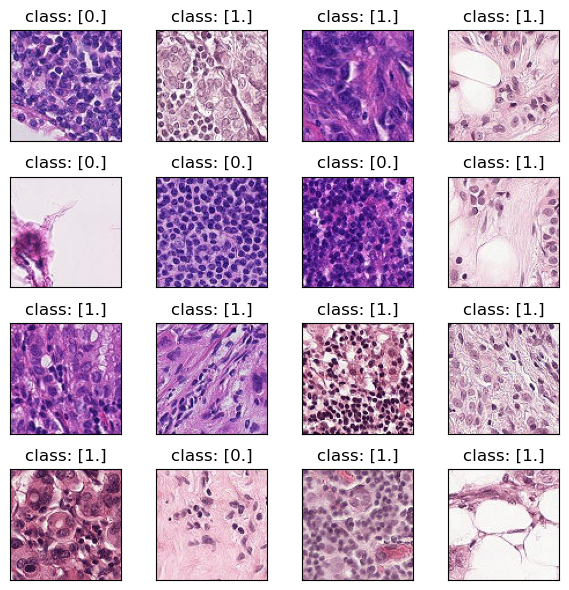

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    axs[i//4][i%4].imshow(train_dataset[i][0].permute(1, 2, 0).numpy())
    axs[i//4][i%4].set_xticks([])
    axs[i//4][i%4].set_yticks([])
    axs[i//4][i%4].set_title(f"class: {train_dataset[i][1]}")
plt.tight_layout()

In [8]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count())
valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False, num_workers=os.cpu_count())

# Residual Networks
In recent years, neural networks have become deeper, with state-of-the-art networks going from just a few layers to over a hundred layers.

* The main benefits of deep networks are that they can represent very complex functions and learn features at different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output).
* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent slow.
* More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode" to take very large values).

Residual networks try to solve this problem by using skip connections as explained in the next section.

## 1 - Building blocks and construction

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="https://theaisummer.com/static/8d19d048cd68d6dce362e025cf3b635a/1ac66/skip-connection.png" scale="50%">
<caption><center> A ResNet block showing a skip-connection <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

### 1.1 - The identity block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation ($a^{[l]}$) has the same dimension as the output activation ($a^{[l+2]}$).
In this exercise, you will implement an identity block in which the skip connection "skips over" 3 hidden layers:

<img src="https://drive.google.com/thumbnail?id=17ogAibvwczsmgQvXVvEbqg8aY4tAgdwr&sz=s800">
<caption><center> Identity block. Skip connection "skips over" 3 layers. </center></caption>

The upper path is the "shortcut path". The lower path is the "main path" with convolutional layers and ReLu activation functions. As introduced in the other laboratories, to speed up training we also add BatchNorm layers.  

Here are the individual steps.

**First component** of main path:
- CONV2D with $F_1$ filters of shape (1, 1), stride of (1, 1), padding "valid".
- BatchNorm, normalizing the 'channels' axis.
- ReLU activation function.

**Second component** of main path:
- CONV2D with $F_2$ filters of shape $(f, f)$, stride of (1, 1), padding "same".
- BatchNorm, normalizing the 'channels' axis.
- ReLU activation function.

**Third component** of main path:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (1, 1), padding "valid".
- BatchNorm, normalizing the 'channels' axis.
- Note that there is **no** ReLU activation function in this component.

**Final step**:
- Add together the `X_input` and the output from the 3rd layer `X` (shortcut).
- ReLU activation function.

In [9]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU

class MainPath(Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2, F3 = filters
        self.main_path = Sequential(
            # First component.
            Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            BatchNorm2d(F1),
            ReLU(),
            
            # Second component.
            Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            BatchNorm2d(F2),
            ReLU(),

            # Third component.
            Conv2d(F2, F3, kernel_size=1),
            BatchNorm2d(F3),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y

### 1.2 - The convolutional block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:

<img src="https://drive.google.com/thumbnail?id=1Lui0TVFvqyFleATruaKej37XgkzbpxlA&sz=s600">
<caption><center> Convolutional block </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path.  
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2.
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.

The details of the convolutional block are as follows.

**First component** of main path:
- CONV2D with $F_1$ filters of shape (1, 1), stride of (s, s), padding "valid".
- BatchNorm.
- ReLU activation function.

**Second component** of main path:
- CONV2D with $F_2$ filters of shape (f, f), stride of (1, 1), padding "same".
- BatchNorm.
- ReLU activation function.

**Third component** of main path:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (1,1), padding "valid".
- BatchNorm.
Note that there is no ReLU activation function in this component.

**Shortcut path**:
- CONV2D with $F_3$ filters of shape (1, 1), stride of (s, s), padding "valid".
- BatchNorm.

**Final step**:
- Add together the shortcut and the main path values.
- ReLU activation function.

In [10]:
class ConvolutionalBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size, stride=2)
        self.relu = ReLU()
        
        # We just need the third number.
        _, _, F3 = filters
        self.shortcut_path = Sequential(
            Conv2d(in_channels, F3, kernel_size=1, stride=2),
            BatchNorm2d(F3)
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.shortcut_path(x) + self.main_path(x))
        return y

### 1.3 - Building the ResNet model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x n" means you should stack n identity blocks together.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*VM94wVftxP7wkiKo4BjfLA.png">
<caption><center> ResNet50 </center></caption>

The details of this ResNet-50 model are:
- Stage 1:
    - 2D Convolution with 64 filters of shape (7, 7) and stride of (2, 2).
    - BatchNorm, applied to the 'channels' axis of the input.
    - MaxPooling with (3, 3) window and (2, 2) stride.
- Stage 2:
    - Convolutional block with three sets of filters of size [64, 64, 256], `f = 3` and `s = 1`.
    - 2 identity blocks with three sets of filters of size [64,64,256], `f = 3`.
- Stage 3:
    - Convolutional block with three sets of filters of size [128, 128, 512], `f = 3` and `s = 2`.
    - 3 identity blocks with three sets of filters of size [128, 128, 512], `f = 3`.
- Stage 4:
    - Convolutional block with three sets of filters of size [256, 256, 1024], `f = 3` and `s = 2`.
    - 5 identity blocks with three sets of filters of size [256, 256, 1024], `f = 3`.
- Stage 5:
    - Convolutional block with three sets of filters of size [512, 512, 2048], `f = 3` and `s = 2`.
    - 2 identity blocks with three sets of filters of size [512, 512, 2048], `f = 3`.
- 2D Average Pooling with window of shape (2, 2).
- Flatten layer.
- Fully Connected (Dense) layer reduces its input to one single neuron at output using sigmoid activation.

Implement below the ResNet50 model.

In [11]:
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout
class ResNet50(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            # Stage 1:
            Conv2d(3, 64, kernel_size=7, stride=2),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=3, stride=2),
            
            # Stage 2:
            ConvolutionalBlock(in_channels=64, filters=[64, 64, 256], kernel_size=3),
            IdentityBlock(in_channels=256, filters=[64, 64, 256], kernel_size=3),
            IdentityBlock(in_channels=256, filters=[64, 64, 256], kernel_size=3),
            
            # Stage 3:
            ConvolutionalBlock(in_channels=256, filters=[128, 128, 512], kernel_size=3),
            IdentityBlock(in_channels=512, filters=[128, 128, 512], kernel_size=3),
            IdentityBlock(in_channels=512, filters=[128, 128, 512], kernel_size=3),
            IdentityBlock(in_channels=512, filters=[128, 128, 512], kernel_size=3),

            # Stage 4:
            ConvolutionalBlock(in_channels=512, filters=[256, 256, 1024], kernel_size=3),
            IdentityBlock(in_channels=1024, filters=[256, 256, 1024], kernel_size=3),
            IdentityBlock(in_channels=1024, filters=[256, 256, 1024], kernel_size=3),
            IdentityBlock(in_channels=1024, filters=[256, 256, 1024], kernel_size=3),
            IdentityBlock(in_channels=1024, filters=[256, 256, 1024], kernel_size=3),
            IdentityBlock(in_channels=1024, filters=[256, 256, 1024], kernel_size=3),

            # Stage 5:
            ConvolutionalBlock(in_channels=1024, filters=[512, 512, 2048], kernel_size=3),
            IdentityBlock(in_channels=2048, filters=[512, 512, 2048], kernel_size=3),
            IdentityBlock(in_channels=2048, filters=[512, 512, 2048], kernel_size=3),
            AvgPool2d(kernel_size=2, stride=2)
        )
        self.classification_layer = Linear(2048, 1)
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).squeeze()
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


In [12]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
model = ResNet50()
opt = SGD(model.parameters(), lr=1e-2, weight_decay = 0, momentum=0.5)
loss_fn = BCEWithLogitsLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs=10
best_val = np.inf
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_x)

        loss = loss_fn(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
        print(f"loss: {val_loss}, accuracy: {val_acc}")

    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "model.pt")
        best_val = val_loss



Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 146.34it/s]


loss: 0.4029811348082717, accuracy: 0.81463623046875
Saved Model
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 144.92it/s]


loss: 0.3634842234537719, accuracy: 0.848785400390625
Saved Model
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 144.96it/s]


loss: 0.5773027207549957, accuracy: 0.80718994140625
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 145.14it/s]


loss: 0.4332046093527309, accuracy: 0.837615966796875
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 145.17it/s]


loss: 0.37683103116986116, accuracy: 0.8553466796875
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 144.84it/s]


loss: 0.3891625439119146, accuracy: 0.832611083984375
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 145.94it/s]


loss: 0.39518047506651666, accuracy: 0.847869873046875
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 145.82it/s]


loss: 0.37070257871682355, accuracy: 0.84808349609375
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 145.04it/s]


loss: 0.7540712467454693, accuracy: 0.74627685546875
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 146.16it/s]

loss: 0.5017650022224082, accuracy: 0.810699462890625


In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score

def evaluate_network(dataloader, model, data_split):
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        loss = loss_fn(predictions, true).detach().cpu().numpy()
        predictions = torch.sigmoid(predictions).detach().cpu().numpy()
        true = true.detach().cpu().numpy()

        fpr, tpr, thresholds = roc_curve(true, predictions)
        auc = roc_auc_score(true, predictions)
        predictions = predictions.round()
        precision, recall, fscore, _= precision_recall_fscore_support(true, predictions, average='binary')
        accuracy = accuracy_score(true, predictions)

        print(f"{data_split} loss: {loss}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {fscore}, roc_auc: {auc}")

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{data_split} receiver operating characteristic (ROC)')
        plt.legend(loc="lower right")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:27<00:00, 149.10it/s]


Training Dataset loss: 0.29383871838975034, accuracy: 0.8760185241699219, precision: 0.825456466470763, recall: 0.9536972045898438, f1: 0.8849550630603843, roc_auc: 0.9611307446903083


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 146.89it/s]


Validation Dataset loss: 0.3634842234537719, accuracy: 0.848785400390625, precision: 0.8175495214778544, recall: 0.8976113385057121, f1: 0.8557118313386332, roc_auc: 0.9257649622750153


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:03<00:00, 146.77it/s]


Test Dataset loss: 0.48948479429218084, accuracy: 0.7860107421875, precision: 0.7961545759281513, recall: 0.7686389448616963, f1: 0.7821548403131602, roc_auc: 0.8684599680995138


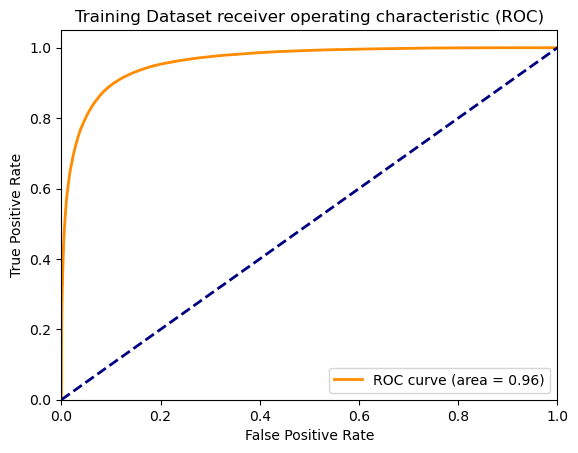

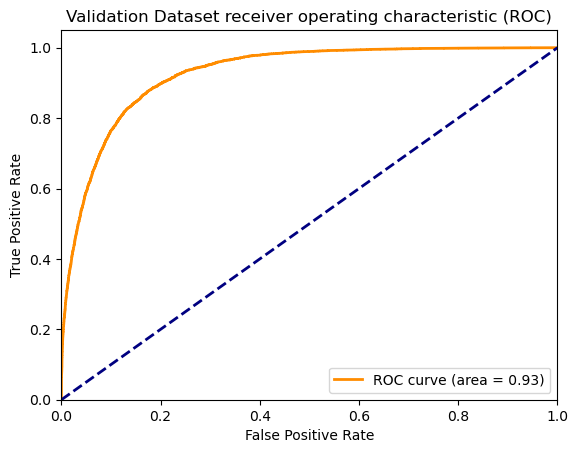

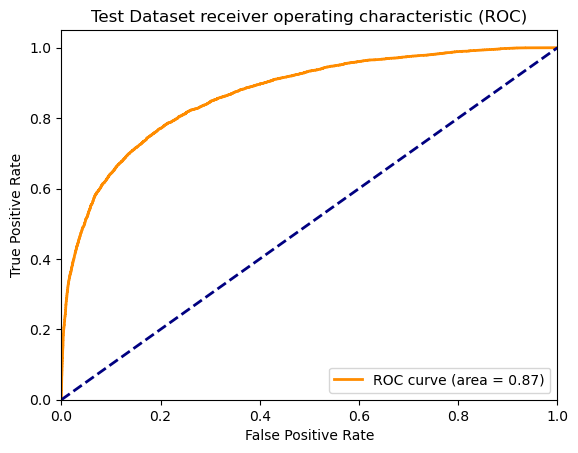

In [14]:
model.load_state_dict(torch.load("model.pt"))
evaluate_network(train_dataloader, model, "Training Dataset")
evaluate_network(valid_dataloader, model, "Validation Dataset")
evaluate_network(test_dataloader, model, "Test Dataset")

# Inception network

In a pure Inception network there are two different block types: the *Inception blocks* and the *Reduction blocks*.

Inception-v4 is composed of three different Inception blocks, two Reduction ones and an initial stem block.

<img src="https://developer.ridgerun.com/wiki/images/thumb/2/29/Inceptionv4.png/720px-Inceptionv4.png" width="500px">
<caption><center>  <br> </center></caption>

### Rationale behind Inception layers

Inception layers are usually built by runnining in parallel multiple different branches. As an example see the Inception-A block.

<img src="https://drive.google.com/thumbnail?id=1wth4q2nf9h4d4JTwmrAhLVzb5pFyIRCd&sz=s600">
<caption><center> Inception-A block. </center></caption>

The main improvements introduced by the inception network are the following:

* **Since the various branches of a layer have filters of different sizes, they will focus on features with different scales.** This is usually obtained by either increasing the kernel size of the filters or by stacking multiple Conv layers one after the other. For example by stacking two 3x3 layers the receptive field at the output is going to be 5x5. This considerably increases the feature extraction capability of the model.

* The 1x1 convolutional layers introduced before each branch are used to reduce considerably the total number of operations in the network (FLOPS). Consider the fact that a conv layer with kernel size NxN and F filters that processes an input of size HxWxC computes approximately N\*N\*F\*H\*W\*C operations. Given this it is possible to see that in general if we simply apply a NxN convolutional layer we get in total N\*N\*F\*H\*W\*C operations while by adding a 1x1 layer first that has a number of output filters F1 < C then we get a total number of operations equal to H\*W\*(F1\*C + N\*N\*F2\*F1) operations. It is easy to see that this is in general less FLOPs than when running a single NxN layer if F1 is small enough. Of course the bigger N the better the gain in terms of computational complexity. **What the 1x1 convolutional filter actually does is that it performs dimensionality reduction since it is simply reducing the number of channels in the input representation while retaining as much information as possible.**
For example in the Inception-A block the 1x1 convolution + 3x3 convolution reduces the total number of operations from 3\*3\*96\*H\*W\*384 = 331776\*H\*W
to H\*W(384\*64 + 3\*3\*64\*96) = 79872 \*H\*W  which is a 4x improvement and the gap increases considerably when we increase the filter size (e.g. 7x7)

* The authors have shown that expecially for big filters it is possible to reduce the overall number of FLOPs considerably at the price of very low performance loss by substituting NxN convolutional layers with two layers one with filters of size Nx1, and one with filters of size Nx1. The resulting receptive field is the same and the performance does not change much, however the total number of operations is 2\*N\*F\*H\*W\*C instead of N\*N\*F\*H\*W\*C. Additionally if the first layer also reduces the number of channels of the input then extra operations are saved.

* For the same reason also stacking multiple 3x3 layers is usually better than using a 5x5 or 7x7 layer in terms of number of operations while maintaining the same receptive field.

All of these tricks allow defining a very powerful model but that is much more efficient w.r.t. the naive definition that simply stacks NxN convolutions.

## 1 - Inception-v4 Building blocks
### 1.1 - Convolutional and batch normalization helper function
First of all, here below is implemented the ``Conv2d_bn`` helper module that you will use in all the blocks of the Inception v4 network.

Use the following structure:
- CONV2D with $F$ filters of shape ($h$, $w$), stride of ($s_1$, $s_2$).
- BatchNorm, normalizing the 'channels' axis.  
- ReLU activation function.

In [15]:
class Conv2d_bn(Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides, padding):
        super().__init__()
        if isinstance(kernel_size, tuple):
            padding_val = (k // 2 for k in kernel_size) if padding == "same" else (0,0)
        else:
            padding_val = kernel_size // 2 if padding == "same" else 0
        self.conv = Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=strides, padding=padding_val)
        self.bn = BatchNorm2d(out_filters)
        self.relu = ReLU()
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

### 1.2 - The stem block

The stem block is designed as follows:

<img src="https://docs.google.com/thumbnail?id=1khnXIQE8l2A1xVNU9BkMvHH2foAnpOhm&sz=s800">
<caption><center> Stem block. </center></caption>

Implement below all the steps by taking advantage of the above implemented ``conv2d_bn`` function for the blue rectangles. The values for the kernel sizes and the strides are specified in each block, use stride 1x1 when it is not specified. Use padding "valid" when the letter *V* appears otherwise use padding "same". E.g., the first layer has the following parameters: 32 filters of shape (3, 3), stride of (2, 2), padding "valid" while the third one is composed of 64 filters of shape (3, 3), stride of (1, 1), padding "same".

For the **Filter concat** layers (orange rectangles), you can use the torch.cat function and concatenate along the 'channel' axis (axis=1).

In [16]:
class StemBlock(Module):

    def __init__(self):
        super().__init__()
        
        self.first_block = Sequential(
            Conv2d_bn(3, 32, kernel_size=3, strides=2, padding="valid"),
            Conv2d_bn(32, 32, kernel_size=3, strides=1, padding="valid"),
            Conv2d_bn(32, 64, kernel_size=3, strides=1, padding="same"),
        )
        
        self.first_left = MaxPool2d(kernel_size=3, stride=2, padding=0) # Padding 0 is the same as "valid"
        self.first_right = Conv2d_bn(64, 96, kernel_size=3, strides=2, padding="valid")
        
        self.second_left =  Sequential(
            Conv2d_bn(160, 64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(64, 96, kernel_size=3, strides=1, padding="valid"),
        )
        
        self.second_right =  Sequential(
            Conv2d_bn(160, 64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(64, 64, kernel_size=(7,1), strides=1, padding="same"),
            Conv2d_bn(64, 64, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(64, 96, kernel_size=3, strides=1, padding="valid"),
        )
        
        self.third_left = Conv2d_bn(192, 192, kernel_size=3, strides=2, padding="valid")
        self.third_right = MaxPool2d(kernel_size=3, stride=2, padding=0) # Padding 0 is the same as "valid"
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x = self.first_block(x)
        x = torch.cat((self.first_left(x), self.first_right(x)), dim=1)
        x = torch.cat((self.second_left(x), self.second_right(x)), dim=1)
        x = torch.cat((self.third_left(x), self.third_right(x)), dim=1)
        return x

In [17]:
model = StemBlock()
print(model(torch.zeros((1, 3, 299, 299))).shape)
print(f"Expected shape (1, 384, 35, 35)")

torch.Size([1, 384, 35, 35])
Expected shape (1, 384, 35, 35)


### 1.3 - The Inception-A block

Implement below the Inception-A block as in the figure:

<img src="https://drive.google.com/thumbnail?id=1gFWs_UGIiN3c-axas4r6T5yx79Ng0I3P&sz=s600">
<caption><center> Inception-A block. </center></caption>

In [18]:
class A_block(Module):

    def __init__(self, in_filters):
        super().__init__()
        
        self.avg_block = Sequential(
            AvgPool2d(kernel_size=3, stride=1, padding=1),
            Conv2d_bn(in_filters, 96, kernel_size=1, strides=1, padding="same"),
        )
        
        self.one_by_one_block = Conv2d_bn(in_filters, 96, kernel_size=1, strides=1, padding="same")
        
        self.three_by_three_block =  Sequential(
            Conv2d_bn(in_filters, 64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(64, 96, kernel_size=3, strides=1, padding="same"),
        )
        
        self.five_by_five =  Sequential(
            Conv2d_bn(in_filters, 64, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(64, 96, kernel_size=3, strides=1, padding="same"),
            Conv2d_bn(96, 96, kernel_size=3, strides=1, padding="same"),
        )
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
    def forward(self, x):
        x_lst = [
            self.avg_block(x),
            self.one_by_one_block(x),
            self.three_by_three_block(x),
            self.five_by_five(x)
        ]
        x = torch.cat(x_lst, dim=1)
        return x

In [19]:
a_block = A_block(384)
print(a_block(torch.zeros(1, 384, 35, 35)).shape)
print(f"Expected shape (1, 384, 35, 35)")

torch.Size([1, 384, 35, 35])
Expected shape (1, 384, 35, 35)


### 1.4 - The Inception-B block

Implement below the Inception-B block as in the figure:

<img src="https://drive.google.com/thumbnail?id=1xWVMCo8-ZO2db0MobJhkNXCUe3ADAxFj&sz=s600">
<caption><center> Inception-B block. </center></caption>

In [20]:
class B_block(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.avg_block = Sequential(
            AvgPool2d(kernel_size=3, stride=1, padding=1),
            Conv2d_bn(in_filters, 128, kernel_size=1, strides=1, padding="same"),
        )
        self.one_by_one_block = Conv2d_bn(in_filters, 384, kernel_size=1, strides=1, padding="same")

        self.seven_by_seven_block =  Sequential(
            Conv2d_bn(in_filters, 192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(192, 224, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(224, 256, kernel_size=(7, 1), strides=1, padding="same"),
        )

        self.thirteen_by_thirteen_block =  Sequential(
            Conv2d_bn(in_filters, 192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(192, 192, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(192, 224, kernel_size=(7, 1), strides=1, padding="same"),
            Conv2d_bn(224, 224, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(224, 256, kernel_size=(7, 1), strides=1, padding="same"),
        )
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_lst = [
            self.avg_block(x),
            self.one_by_one_block(x),
            self.seven_by_seven_block(x),
            self.thirteen_by_thirteen_block(x),
        ]
        return x

In [21]:
b_block = B_block(1024)
print(b_block(torch.zeros(1, 1024, 17, 17)).shape)
print(f"Expected shape (1, 1024, 17, 17)")

torch.Size([1, 1024, 17, 17])
Expected shape (1, 1024, 17, 17)


### 1.5 - The Inception-C block

Implement below the Inception-C block as in the figure:

<img src="https://drive.google.com/thumbnail?id=1RqRqHPnshE4B_G1F2atbTmJ7DrzbGs_9&sz=s600">
<caption><center> Inception-C block. </center></caption>


In [22]:
class C_block(Module):

    def __init__(self, in_filters):
        super().__init__()
        
        self.avg_block = Sequential(
            AvgPool2d(3, stride=1, padding=1),
            Conv2d_bn(in_filters, 256, kernel_size=1, strides=1, padding="same"),
        )
        
        self.one_by_one_block = Conv2d_bn(in_filters, 256, kernel_size=1, strides=1, padding="same")

        self.branch_a =  Conv2d_bn(in_filters, 384, kernel_size=1, strides=1, padding="same")
        
        self.branch_a_left = Conv2d_bn(384, 256, kernel_size=(1, 3), strides=1, padding="same")
        
        self.branch_a_right = Conv2d_bn(384, 256, kernel_size=(3, 1), strides=1, padding="same")

        self.branch_b =  Sequential(
            Conv2d_bn(in_filters, 384, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(384, 448, kernel_size=(1, 3), strides=1, padding="same"),
            Conv2d_bn(448, 512, kernel_size=(3, 1), strides=1, padding="same"),
        )

        self.branch_b_left = Conv2d_bn(512, 256, kernel_size=(1, 3), strides=1, padding="same")
        self.branch_b_right = Conv2d_bn(512, 256, kernel_size=(3, 1), strides=1, padding="same")


        self.branch_b_left = Conv2d_bn(512, 256, kernel_size=(1, 3), strides=1, padding="same")
        self.branch_b_right = Conv2d_bn(512, out_filters=256, kernel_size=(3, 1), strides=1, padding="same")
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        a_branch = self.branch_a(x)
        b_branch = self.branch_b(x)
        x_lst = [
            self.avg_block(x),
            self.one_by_one_block(x),
            self.branch_a_left(a_branch),
            self.branch_a_right(a_branch),
            self.branch_b_left(b_branch),
            self.branch_b_right(b_branch),
        ]
        x = torch.cat(x_lst, dim=1)
        return x

In [23]:
c_block = C_block(1536)
print(c_block(torch.zeros(1, 1536, 8, 8)).shape)
print(f"Expected shape (1, 1536, 8, 8)")

torch.Size([1, 1536, 8, 8])
Expected shape (1, 1536, 8, 8)


### 1.6 - The Reduction-A block

Implement below the Reduction-A block as in the figure:

<img src="https://drive.google.com/thumbnail?id=1LtkLxcBOyJtVBikmY-ljspXhwCZlkHF1&sz=s600">
<caption><center> Reduction-A block. </center></caption>

For the Inception-v4 the parameters are as follows:
- n = 384
- k = 192
- l = 224
- m = 256

In [24]:
class Reduction_A(Module):

    def __init__(self, in_filters):
        super().__init__()
        self.max_pool = MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.central_block = Conv2d_bn(in_filters=in_filters, out_filters=384, kernel_size=3, strides=2, padding="valid")
        
        self.right_block =  Sequential(
            Conv2d_bn(in_filters, 192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(192, 224, kernel_size=3, strides=1, padding="same"),
            Conv2d_bn(224, 256, kernel_size=3, strides=2, padding="valid"),
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_lst = [
            self.max_pool(x),
            self.central_block(x),
            self.right_block(x)
        ]
        x = torch.cat(x_lst, dim=1)
        return x

In [25]:
reduction_A = Reduction_A(384)
print(reduction_A(torch.zeros(1, 384, 35, 35)).shape)
print("Expected shape (1, 1024, 17, 17)")

torch.Size([1, 1024, 17, 17])
Expected shape (1, 1024, 17, 17)


### 1.7 - The Reduction-B block

Implement below the Reduction-B block as in the figure:

<img src="https://drive.google.com/thumbnail?id=18qKx5NE0i6U41EZnFhejYcTRnS_jlzp4&sz=s600">

<caption><center> Reduction-B block. </center></caption>

In [26]:
class Reduction_B(Module):

    def __init__(self, in_filters):
        super().__init__()
        
        self.max_pool = MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.central_block = Sequential(
            Conv2d_bn(in_filters, 192, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(192, 192, kernel_size=3, strides=2, padding="valid"),
        )
        
        self.right_block =  Sequential(
            Conv2d_bn(in_filters, 256, kernel_size=1, strides=1, padding="same"),
            Conv2d_bn(256, 256, kernel_size=(1, 7), strides=1, padding="same"),
            Conv2d_bn(256, 320, kernel_size=(7, 1), strides=1, padding="same"),
            Conv2d_bn(320, 320, kernel_size=3, strides=2, padding="valid"),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x_lst = [
            self.max_pool(x),
            self.central_block(x),
            self.right_block(x)
        ]
        x = torch.cat(x_lst, dim=1)
        return x

In [27]:
reduction_B = Reduction_B(1024)
print(reduction_B(torch.zeros(1, 1024, 17, 17)).shape)
print("Expected shape (1, 1536, 8, 8)")

torch.Size([1, 1536, 8, 8])
Expected shape (1, 1536, 8, 8)


In [28]:
from torch.nn import Dropout
class InceptionV4(Module):

    def __init__(self):
        super().__init__()
        
        self.stem = StemBlock()
        
        self.inception_a = Sequential(
            A_block(384),
            A_block(384),
            A_block(384),
            A_block(384)
        )
        
        self.reduction_a = Reduction_A(384)
        
        self.inception_b = Sequential(
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024),
            B_block(1024)
        )
        
        self.reduction_b = Reduction_B(1024)
        
        self.inception_c = Sequential(
            C_block(1536),
            C_block(1536),
            C_block(1536)
        )

        self.drop = Dropout(0.2)
        
        self.out = Linear(1536, 1)
        
        self.apply(self._init_weights)

    def forward(self, x):
        x = self.stem(x)
        x = self.inception_a(x)
        x = self.reduction_a(x)
        x = self.inception_b(x)
        x = self.reduction_b(x)
        x = self.inception_c(x)
        #print(x.shape)
        x = x.reshape(x.shape[0], -1, 1536) 
        #print(x.shape) # x.shape = (x.shape[0], N, 1536)
        x = x.mean(axis=1)
        #print(x.shape) # x.shape = (x.shape[0], 1536)
        x = self.drop(x)
        y = self.out(x)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

In [29]:
inception_v4 = InceptionV4()
print(inception_v4(torch.zeros(1, 3, 299, 299)).shape)
print("Expected shape (1, 1)")


torch.Size([1, 1])
Expected shape (1, 1)


In [30]:
model = InceptionV4()
opt = SGD(model.parameters(), lr=0.005, momentum=0.5)
loss_fn = BCEWithLogitsLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
epochs=10
best_val = np.inf
for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        y_pred = model(batch_x)

        loss = loss_fn(y_pred, batch_y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
        print(f"loss: {val_loss}, accuracy: {val_acc}")

    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "model.pt")
        best_val = val_loss

Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 77.54it/s]


loss: 0.3826092633739129, accuracy: 0.81842041015625
Saved Model
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 77.67it/s]


loss: 0.43908438062583627, accuracy: 0.809051513671875
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 77.46it/s]


loss: 0.353925267627494, accuracy: 0.844879150390625
Saved Model
Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 77.51it/s]


loss: 0.3652475081349833, accuracy: 0.846832275390625
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 77.55it/s]


loss: 0.32759402606661336, accuracy: 0.8614501953125
Saved Model
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 76.55it/s]


loss: 0.3337195709193785, accuracy: 0.861419677734375
Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 76.64it/s]


loss: 1.2808923190321735, accuracy: 0.688690185546875
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 76.95it/s]


loss: 1.2712642960016924, accuracy: 0.63848876953125
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 76.57it/s]


loss: 0.45220051250979176, accuracy: 0.80908203125
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 76.48it/s]

loss: 0.353305379159755, accuracy: 0.85888671875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4096/4096 [00:51<00:00, 79.74it/s]


Training Dataset loss: 0.17690734331363162, accuracy: 0.9314422607421875, precision: 0.9119498229817736, recall: 0.9551010131835938, f1: 0.9330267639539996, roc_auc: 0.9828979784215335


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 76.51it/s]


Validation Dataset loss: 0.32759402606661336, accuracy: 0.8614501953125, precision: 0.888319873941304, recall: 0.8265624045451768, f1: 0.8563291139240506, roc_auc: 0.9397054964070644


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:06<00:00, 76.50it/s]


Test Dataset loss: 0.43943060836682607, accuracy: 0.812042236328125, precision: 0.8908353733170135, recall: 0.7110581913659401, f1: 0.7908587727936432, roc_auc: 0.9086830672825511


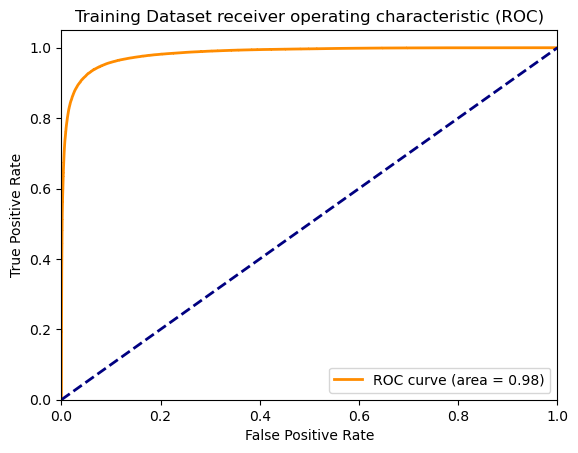

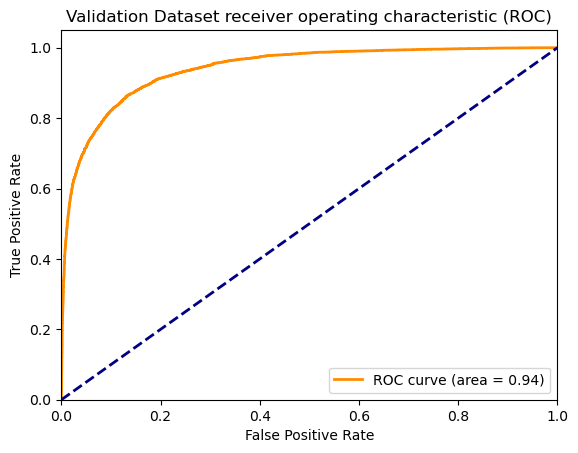

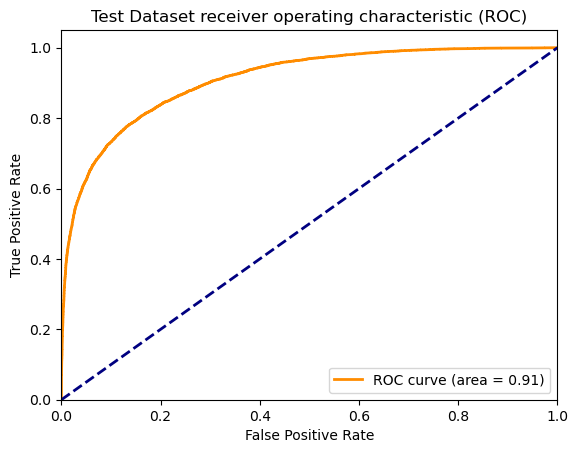

In [31]:
model.load_state_dict(torch.load("model.pt"))
evaluate_network(train_dataloader, model, "Training Dataset")
evaluate_network(valid_dataloader, model, "Validation Dataset")
evaluate_network(test_dataloader, model, "Test Dataset")